In [4]:
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline
import pandas as pd
import os
import glob
import matplotlib.pylab as plt
from pygam import PoissonGAM, s, te
from pygam.datasets import chicago
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.gam.tests.test_penalized import df_autos
from statsmodels.gam.smooth_basis import (BSplines, CubicSplines,
                                          CyclicCubicSplines)
from pygam import LinearGAM, s,f,te
from sklearn.metrics import PredictionErrorDisplay

from pygam.datasets import mcycle
from sklearn.metrics import mean_squared_error
from pickle import dump, load
import math
import pickle
import sys
import seaborn as sns
import sys
from pathlib import Path
sys.path.append('/home/scarlett/github/Ipy_notebook')  
#from Python.ROC_noLAMBDA import ROC_comparison_fix3_beta, ROC_comparison_fix3_sigma, ROC_comparison_fix3_noLambda, ROC_comparison_fix3_Lambda, get_ROC_AUC
from Python.quickBeast import get_filename, calculate_AUC_qb, Calculate_power_type1error_for_posterior,Calculate_power_type1error_pval,get_qb_p_values, get_data
from Python.functions import plot_3_hist,get_success_sample,clean_data,plot_posterior_mass_support_alt,plot_lambda,table_by_hets,table_totalcount
from Python.power import predict_lambda_from_realdata,Calculate_cutoff
from Python.ROC_common import calculate_posterior_value
from Python.read_data import read_one_pickle, get_NS_p_values
from BEASTIE import predict_lambda_GAM
from math import log,log2
import fnmatch
from prettytable import PrettyTable
import statistics


### QuickBEAST

In [3]:
file_a="/data2/NA12878/beastie/runModel_phased_even101/chr1-22_alignBiasp0.05_s0.7_a0.05_sinCov0_totCov1_W1000K1000/tmp/NA12878_real_alignBiasafterFilter.phasedByshapeit2.cleaned.tsv"
file_b="/data2/NA12878/beastie/runModel_phased_even101/chr1-22_alignBiasp0.05_s0.7_a0.05_sinCov0_totCov1_W1000K1000/tmp/quickBEASTIE_input"
untransformed = pd.read_csv('/data2/NA12878/beastie/runModel_phased_even101/chr1-22_alignBiasp0.05_s0.7_a0.05_sinCov0_totCov1_W1000K1000/tmp/NA12878_real_alignBiasafterFilter.phasedByshapeit2.cleaned.forlambda.tsv', sep='\t')
untransformed.head()

,geneID,median.altRatio,number.of.hets,total.patCount,total.matCount,totalCount
0,ENSG00000000460.12,1.000000,2,0,4,4
1,ENSG00000001036.9,0.518182,5,527,594,1121
2,ENSG00000001084.6,0.428571,3,7,9,16
3,ENSG00000001460.13,0.400000,1,3,2,5
4,ENSG00000001461.12,0.476923,1,34,31,65


In [4]:
def convert_to_file_b_format(gene_id, site_data):
    site_lines = []
    for idx, (mat_count, pat_count) in enumerate(site_data, start=1):
        site_line = "(site {} (mat {}) (pat {}) (phaseCorrect 1))".format(idx, mat_count, pat_count)
        site_lines.append(site_line)

    output = f"(gene {gene_id} (theta 1.0) {' '.join(site_lines)})"
    return output
    
    gene_block = (
        "(gene {}\n"
        "\t(theta 1.0)\n"
        "{}\n"
        "))"
    ).format(gene_id, "\n".join(site_lines))
    return gene_block

def read_file_a(file_path):
    gene_data = {}
    with open(file_path, 'r') as file:
        next(file)  # Skip header line
        for line in file:
            parts = line.strip().split('\t')
            gene_id = parts[5]
            ref_count = int(parts[7])
            alt_count = int(parts[8])
            if gene_id not in gene_data:
                gene_data[gene_id] = []
            gene_data[gene_id].append((alt_count, ref_count))  # Swap alt_count and ref_count
    return gene_data

In [5]:
gene_data = read_file_a(file_a)

file_b_blocks = []
for gene_id, site_data in gene_data.items():
    file_b_blocks.append(convert_to_file_b_format(gene_id, site_data))


file_b_content = '\n'.join(file_b_blocks)

with open(file_b, 'w') as file:
    file.write(file_b_content)

In [6]:
gene_data

{'ENSG00000187583.6': [(1, 2), (3, 1)],
 'ENSG00000188290.6': [(4, 1)],
 'ENSG00000187608.5': [(1664, 1548)],
 'ENSG00000188157.9': [(63, 66),
  (98, 104),
  (29, 48),
  (49, 68),
  (42, 64),
  (23, 44),
  (74, 80),
  (115, 141),
  (157, 194)],
 'ENSG00000237330.2': [(1, 0), (2, 0)],
 'ENSG00000131591.13': [(16, 32),
  (37, 39),
  (15, 9),
  (15, 15),
  (15, 16),
  (8, 4)],
 'ENSG00000127054.14': [(47, 32), (17, 10)],
 'ENSG00000162576.12': [(1, 2)],
 'ENSG00000242485.1': [(303, 300)],
 'ENSG00000235098.4': [(1, 0)],
 'ENSG00000160075.10': [(1, 0), (54, 62)],
 'ENSG00000228594.1': [(2, 5)],
 'ENSG00000197530.8': [(0, 1), (3, 6), (8, 12), (11, 5), (18, 7), (1, 1)],
 'ENSG00000008130.11': [(69, 65), (24, 17)],
 'ENSG00000078369.13': [(2, 4)],
 'ENSG00000157933.9': [(9, 11), (5, 11)],
 'ENSG00000116151.9': [(1, 5), (2, 4)],
 'ENSG00000157916.14': [(22, 15), (21, 27), (21, 35), (46, 80)],
 'ENSG00000157911.5': [(29, 24)],
 'ENSG00000149527.13': [(1, 1), (2, 11)],
 'ENSG00000157881.9': [(52

In [7]:
file_a="/data2/QuickBEAST/g-1000_h-9_d-90_t-1.txt"
file_b="/data2/QuickBEAST/qb_g-1000_h-9_d-90_t-1.txt"

In [8]:
def convert_format(file_a, file_b):
    with open(file_a, 'r') as fa, open(file_b, 'w') as fb:
        for line in fa.readlines():
            parts = line.strip().split("\t")
            gene_id = parts[0]
            hets = int(parts[1])
            data = parts[2:2+(2*hets)]
            
            fb.write(f'(gene {gene_id} (theta 1.0) ')
            
            for i in range(hets):
                mat = data[i*2]
                pat = data[(i*2)+1]
                fb.write(f'(site {i+1} (mat {mat}) (pat {pat}) (phaseCorrect 1)) ')
                
            fb.write(")\n")

# usage
convert_format(file_a, file_b)

### Reading the QuickBEAST output

In [9]:
df=pd.read_csv("/data2/QuickBEAST/out2.txt",delimiter="\t",header=None)
df.columns=['geneID','qb_posterior','qb_lambda']
df.head()

,geneID,qb_posterior,qb_lambda
0,ENSG00000090432,0.093582,0.047
1,ENSG00000189410,0.451752,0.063
2,ENSG00000117298,0.233373,0.089
3,ENSG00000162551,0.884309,0.087
4,ENSG00000076864,0.473746,0.060


In [10]:
df_sametype1=pd.read_csv("/data2/QuickBEAST/out_changetype1.txt",delimiter="\t",header=None)
df_sametype1.columns=['geneID','qb_posterior','qb_lambda']
df_sametype1['converted_qB_lambda_right'] = (0.5 + df_sametype1['qb_lambda']) / (1 - (0.5 + df_sametype1['qb_lambda']))
df_sametype1['converted_qB_lambda_left'] = (0.5 - df_sametype1['qb_lambda']) / (1 - (0.5 - df_sametype1['qb_lambda']))
df_sametype1['converted_qB_lambda'] = df_sametype1.apply(lambda row: max(row['converted_qB_lambda_left'], row['converted_qB_lambda_right']), axis=1)
df_sametype1.head()

,geneID,qb_posterior,qb_lambda,converted_qB_lambda_right,converted_qB_lambda_left,converted_qB_lambda
0,ENSG00000142632,0.493863,0.059,1.267574,0.788909,1.267574
1,ENSG00000132881,0.493863,0.059,1.267574,0.788909,1.267574
2,ENSG00000187583,0.262682,0.089,1.433090,0.697793,1.433090
3,ENSG00000188290,0.411539,0.074,1.347418,0.742160,1.347418
4,ENSG00000142733,0.113877,0.149,1.849003,0.540832,1.849003


In [ ]:
len(df)

In [11]:
GAM=pd.read_csv("/data2/NA12878/beastie/runModel_phased_even101/chr1-22_alignBiasp0.05_s0.7_a0.05_sinCov0_totCov1_W1000K1000/iBEASTIE3/NA12878_ASE_all.tsv",delimiter="\t",header=0)
GAM.head()

,Unnamed: 0,geneID,median.altRatio,number.of.hets,total.patCount,total.matCount,totalCount,gam_lambda,median_abs_deviation,posterior_median,...,Pseudo_pval,MajorSite_pval,beta_1_1_pval,beta_10_10_pval,beta_20_20_pval,beta_50_50_pval,beta_100_100_pval,beastie_ASE_gam,NS_ASE,MS_ASE
0,0,ENSG00000000460.12,1.000,2,0,4,4,1.876438,0.610,1.446,...,0.062500,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0
1,1,ENSG00000001036.9,0.518,5,527,594,1121,1.345172,0.074,1.116,...,0.000767,0.003042,0.939394,0.790397,0.707686,0.561734,0.429594,0,0,0
2,2,ENSG00000001084.6,0.429,3,7,9,16,2.761880,0.366,1.101,...,0.401810,1.000000,0.823529,0.580436,0.528881,0.488004,0.472000,0,0,0
3,3,ENSG00000001460.13,0.400,1,3,2,5,1.987493,0.393,0.930,...,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,0,0
4,4,ENSG00000001461.12,0.477,1,34,31,65,2.633816,0.179,0.922,...,0.402159,0.804317,0.969697,0.905421,0.879108,0.847346,0.829731,0,0,0


In [12]:
GAM=pd.read_csv("/data2/NA12878/beastie/runModel_phased_even101/chr1-22_alignBiasp0.05_s0.7_a0.05_sinCov0_totCov1_W1000K1000/iBEASTIE3/NA12878_ASE_all.tsv",delimiter="\t",header=0)
GAM=GAM[["geneID","number.of.hets","log2_posterior_median","posterior_median","gam_lambda","posterior_mass_support_ALT_gam","NaiveSum_pval"]]
GAM['geneID'] = GAM['geneID'].replace('\..*', '', regex=True)
GAM['converted_gam_lambda']=-0.5+GAM['gam_lambda']/(GAM['gam_lambda']+1)
GAM.head()

,geneID,number.of.hets,log2_posterior_median,posterior_median,gam_lambda,posterior_mass_support_ALT_gam,NaiveSum_pval,converted_gam_lambda
0,ENSG00000000460,2,0.531698,1.446,1.876438,0.268,0.125000,0.152348
1,ENSG00000001036,5,0.158143,1.116,1.345172,0.000,0.048647,0.073592
2,ENSG00000001084,3,0.139430,1.101,2.761880,0.003,0.803619,0.234175
3,ENSG00000001460,1,-0.105265,0.930,1.987493,0.100,1.000000,0.165271
4,ENSG00000001461,1,-0.117060,0.922,2.633816,0.000,0.804317,0.224807


In [13]:
len(GAM)

7636

In [14]:
overlapped["converted_qB_lambda"].min()

NameError: name 'overlapped' is not defined

In [15]:
overlapped = pd.merge(GAM, df_sametype1,how='inner', on='geneID')
overlapped=overlapped[["geneID","number.of.hets","gam_lambda","converted_qB_lambda"]]
overlapped.head()

,geneID,number.of.hets,gam_lambda,converted_qB_lambda
0,ENSG00000000460,2,1.876438,1.314815
1,ENSG00000001036,5,1.345172,1.232143
2,ENSG00000001084,3,2.761880,1.785515
3,ENSG00000001460,1,1.987493,1.347418
4,ENSG00000001461,1,2.633816,1.688172


In [16]:
filtered_df = overlapped[overlapped['qb_posterior'] > 0.5]
len(filtered_df)/len(df)

KeyError: 'qb_posterior'

In [ ]:
filtered_df = overlapped[overlapped['posterior_mass_support_ALT_gam'] > 0.5]
len(filtered_df)/len(df)

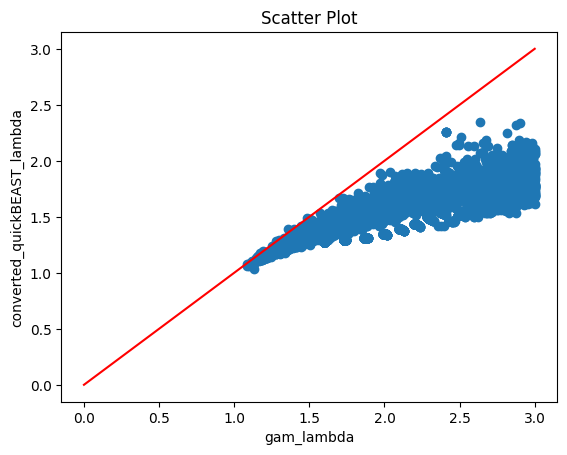

In [17]:
plt.scatter(overlapped["gam_lambda"], overlapped["converted_qB_lambda"])

# Set chart title and label axes
plt.title("Scatter Plot")
plt.xlabel("gam_lambda")
plt.ylabel("converted_quickBEAST_lambda")
plt.plot([0, 3], [0, 3], color='red')
plt.show()  

In [18]:
plt.scatter(overlapped["converted_gam_lambda"], overlapped["quickBEAST_lambda"])

# Set chart title and label axes
plt.title("Scatter Plot")
plt.xlabel("converted_gam_lambda")
plt.ylabel("quickBEAST_lambda")
plt.plot([0, 0.25], [0, 0.25], color='red')
plt.show()  

KeyError: 'converted_gam_lambda'

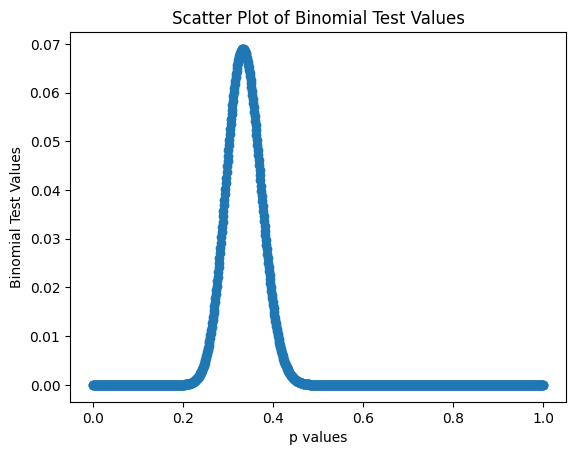

In [19]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

n = 150    # fixed number of trials
x = 50    # fixed number of successes
p_values = np.linspace(0, 1, 1000)     # generate 1000 values of p from 0 to 1
binom_test_values = [binom.pmf(x, n, p) for p in p_values]    # calculate binomial test for each p

# create scatter plot
plt.scatter(p_values, binom_test_values)
plt.title('Scatter Plot of Binomial Test Values')
plt.xlabel('p values')
plt.ylabel('Binomial Test Values')
plt.show()

### check type1error

In [23]:

def Table_power_type1error(POS,NEG,path,alpha_beta,type1error,lambdas = None):
    beastie_power,beastie_qb_power,qb_power,beastie_type1error,beastie_qb_type1error,qb_type1error = Calculate_power_type1error(POS,NEG,path,alpha_beta,type1error,lambdas=lambdas)
    # Plotting the histograms
    print((f"BEASTIE-GAMlambda power = ALT (posterior mass supprt ALT w/ GAM lambda) > 0.5"))
    print((f"BEASTIE-qBlambda  power = ALT (posterior mass supprt ALT w/ converted qb lambda) > 0.5"))
    print((f"qB                power = ALT (qB posterior) > 0.5"))
    print((f"BEASTIE-GAMlambda type1error = REF (posterior mass supprt ALT w/ GAM lambda) > 0.5"))
    print((f"BEASTIE-qBlambda  type1error = REF (posterior mass supprt ALT w/ converted qb lambda) > 0.5"))
    print((f"qB                type1error = REF (qB posterior) > 0.5"))
    Table = PrettyTable(["sample Name", "BEASTIE-GAMlambda (power)", "BEASTIE-qBlambda (power)","qB (power)","BEASTIE-GAMlambda (type1er)", "BEASTIE-qBlambda (type1er)","qB (type1er)"])
    Table.add_row([os.path.splitext(NEG)[0], beastie_power,beastie_qb_power,qb_power,beastie_type1error, beastie_qb_type1error,qb_type1error])
    print(Table)

def print_single_table(n_hets,n_depth,alt,alpha_beta,sigma,expected_type1error):
    print(f">>>> expected type1error at {expected_type1error}, alpha/beta parameter at {alpha_beta}")
    
    model="BEASTIE3-pi0.05"
    path=f"/data2/stan/{model}/sigma{sigma}/parametrized/ASE_0.05_error/output_pkl/"
    NEG=f"g-1000_h-{n_hets}_d-{n_depth}_t-1_s-{sigma}.pickle"
    POS=f"g-1000_h-{n_hets}_d-{n_depth}_t-{alt}_s-{sigma}.pickle"

    DCC_path="/data2/stan"
    candidate_lambdas = np.linspace(1, 3, 2000)
    gam_model= load(open("/home/scarlett/github/BEASTIE/BEASTIE/iBEASTIE4_s0.7_GAM/gam4_lambdamodel.pkl", "rb"))
    predicted_lambda=predict_lambda_GAM.get_lambda_from_gam(gam_model, log(n_hets), log(n_depth), float(expected_type1error),candidate_lambdas)
    print(f"predicted lambda is {predicted_lambda}")
    Table_power_type1error(POS,NEG,path,alpha_beta,expected_type1error,lambdas=predicted_lambda)


# Function to calculate 95% CI
def compute_CI(mean, std, n):
    margin = 1.96 * (std / (n ** 0.5))
    return (mean - margin, mean + margin)

from scipy.stats import norm

def get_z(n_hets,n_depth,theta,alpha_beta,sigma,expected_type1error):
    print(f">>>> expected type1error at {expected_type1error}, alpha/beta parameter at {alpha_beta}")
    
    model="iBEASTIE4"
    path=f"/data2/stan/{model}/sigma{sigma}/parametrized/ASE_0.05_error/output_pkl/"
    NEG=f"g-1000_h-{n_hets}_d-{n_depth}_t-{theta}_s-{sigma}.pickle"

    DCC_path="/data2/stan"
    candidate_lambdas = np.linspace(1, 3, 2000)
    gam_model= load(open("/home/scarlett/github/BEASTIE/BEASTIE/iBEASTIE4_s0.7_GAM/gam4_lambdamodel.pkl", "rb"))
    #predicted_lambda=predict_lambda_GAM.get_lambda_from_gam(gam_model, log(n_hets), log(n_depth), float(expected_type1error),candidate_lambdas)

    BEASTIE,qb = get_data(NEG,path,alpha_beta,expected_type1error)
    return BEASTIE,qb

def plot_single_table(n_hets,n_depth,theta,alpha_beta,sigma,expected_type1error):
    NEG=f"g-1000_h-{n_hets}_d-{n_depth}_t-{theta}_s-{sigma}.pickle"
    BEASTIE,qb = get_z(n_hets,n_depth,theta,alpha_beta,sigma,expected_type1error)
    BEASTIE_mean = calculate_posterior_value("mean",BEASTIE)
    BEASTIE_var = calculate_posterior_value("var",BEASTIE)
    BEASTIE_std = calculate_posterior_value("std",BEASTIE)
    BEASTIE_zscore = calculate_posterior_value("z",BEASTIE)
    qb_mean = qb['qb_mean'].tolist()
    qb_var = qb['qb_var'].tolist()
    qb_std = np.sqrt(qb_var)
    qb_z = qb['qb_zscore'].tolist()
    # Compute summary for Method 1 (iBEASTIE4)
    mean_1_avg = sum(BEASTIE_mean) / len(BEASTIE_mean)
    var_1_avg = sum(BEASTIE_var) / len(BEASTIE_var)
    std_1_avg = sum(BEASTIE_std) / len(BEASTIE_std)
    z_1_avg = sum(BEASTIE_zscore) / len(BEASTIE_zscore)
    # Get parameters of the fitted distribution for iBEASTIE4
    mu, std = norm.fit(BEASTIE_zscore)

    # Compute summary for Method 2 (qB)
    mean_2_avg = sum(qb_mean) / len(qb_mean)
    var_2_avg = sum(qb_var) / len(qb_var)
    std_2_avg = sum(qb_std) / len(qb_std)
    z_2_avg = sum(qb_z) / len(qb_z)
    
    # Printing the table
    Table = PrettyTable([os.path.splitext(NEG)[0], "mean from 1000 datapts", "var from 1000 datapts", "std from 1000 datapts", "Z(MEAN/STD)"])
    Table.add_row(["iBEASTIE4", format(mean_1_avg,'.5f'), format(var_1_avg,'.5f'), format(std_1_avg,'.5f'), format(z_1_avg,'.5f')])
    Table.add_row(["qB", format(mean_2_avg,'.5f'), format(var_2_avg,'.5f'), format(std_2_avg,'.5f'), format(z_2_avg,'.5f')])
    print(Table)

# Plotting
    fig, axs = plt.subplots(1, 4, figsize=(20, 5)) # 1 row, 3 columns

    # Plot for Mean
    axs[0].hist(BEASTIE_mean, bins=30, alpha=.5)
    axs[0].hist(qb_mean, bins=30, alpha=.5)
    axs[0].set_title(f"Mean of {os.path.splitext(NEG)[0]}",fontsize=15)
    axs[0].legend(['iBEASTIE4', 'qB'],fontsize=13)

    # Plot for Std (assuming you want to plot the square root of var as std)
    axs[1].hist(BEASTIE_std, bins=30, alpha=.5)
    axs[1].hist(qb_std, bins=30, alpha=.5)
    axs[1].set_title(f"Std of {os.path.splitext(NEG)[0]}",fontsize=15)
    axs[1].legend(['iBEASTIE4', 'qB'],fontsize=13)

    # Plot for Z Scores
    axs[2].hist(BEASTIE_zscore, bins=30, alpha=.5, label='iBEASTIE4')
    axs[2].hist(qb_z, bins=30, alpha=.5, label='qB')
    axs[2].set_title(f"Z (MEAN/STD) of {os.path.splitext(NEG)[0]}",fontsize=15)
    axs[2].legend(['iBEASTIE4', 'qB'],fontsize=13)

    # Plot PDFs of fitted and original distributions from 1000 NULL genes
    qb_z_1000 = simulate_null_genes(n_hets, n_depth, pi=0.05)
    null_mean = np.mean(qb_z_1000)
    null_std = np.std(qb_z_1000)
    fitted_mean, fitted_std = norm.fit(qb_z_1000)  # Fitting qB z-scores to a normal distribution

    xmin, xmax = axs[2].get_xlim()  # Get xlim from the Z Scores plot
    x = np.linspace(xmin, xmax, 100)
    p_null = norm.pdf(x, null_mean, null_std)
    axs[3].plot(x, p_null, 'k--', linewidth=2, label=f"fitted norm with MLE parameters:\n mu={null_mean:.2f} std={null_std:.2f}")
    p_fitted = norm.pdf(x, fitted_mean, fitted_std)
    axs[3].plot(x, p_fitted, 'r--', linewidth=2, label=f"normal with qb Zscore parameters:\n mean={fitted_mean:.2f} std={fitted_std:.2f}")
    axs[3].set_title("PDFs for 1000 qB Z (MEAN/STD)",fontsize=15)
    axs[3].legend(loc="upper right",fontsize=13)

    plt.tight_layout()
    plt.show()

def simulate_null_genes(number_of_hets, average_read_depth_per_het, pi=0.05):
    # SIMULATE GENE INPUTS
    NUM_GENES = 1
    simulated_genes = []
    for i in range(NUM_GENES):
        gene_id = f"gene_{i}"
        simulated_genes.append(generate_fields(gene_id, M=number_of_hets, D=average_read_depth_per_het, theta=1, switching_error = pi))

    # RUN qb simulated genes 
    simulated_gene_results = run_qb_parallel(simulated_genes)

    # compute summary statistics
    #mean = simulated_gene_results["qb_zscore"].mean()
    #std = simulated_gene_results["qb_zscore"].std()
    qb_z = simulated_gene_results["qb_zscore"].tolist()
    #mean, std = norm.fit(qb_z)
    return qb_z

import subprocess
import tempfile
import logging
import shutil

def write_genes_to_quickbeast_input_file(genes, file_path):
    with open(file_path, 'w') as file:
        for gene in genes:
            gene_id = gene[0]
            hets = gene[1]
            data = gene[2:2+(2*hets)]
            
            file.write(f'(gene {gene_id} (theta 1.0) ')
            
            for i in range(hets):
                mat = data[i*2]
                pat = data[(i*2)+1]
                file.write(f'(site {i+1} (mat {mat}) (pat {pat}) (phaseCorrect 1)) ')
            
            file.write(")\n")

def run_qb_parallel(genes):
    parameter = 8.789625
    type1error = 0.05
    lambdas = 0.04545

    # prepare files
    temp_dir = tempfile.mkdtemp()
    input_file_path = os.path.join(temp_dir, f'input.txt')
    output_file_path = os.path.join(temp_dir, f"output.txt")

    write_genes_to_quickbeast_input_file(genes, input_file_path)
    #run qb
    try:
        subprocess.run([f"/home/scarlett/github/RNAseq-analysis/run_quickBeast/quick_beast_parallel.sh {input_file_path} {parameter} {type1error} {lambdas} > {output_file_path}"], check=True, shell=True)
        # logging.info(f"QB for {input_file_path} executed successfully")
    except subprocess.CalledProcessError as e:
        logging.error(f"Error running QB for {input_file_path}: {e}")

    #read and convert results
    qb = pd.read_csv(output_file_path, delimiter="\t", header=None)
    qb.columns = ['geneID', 'qb_posterior', 'qb_lambda', 'qb_mean', 'qb_var', 'qb_zscore']
    
    # cleanup
    shutil.rmtree(temp_dir)

    return qb

def generate_fields(geneID,M, D, theta,switching_error = 0.05):
    # calculate probability for binomial distribution
    p = theta / (1.0 + theta)
    # calculate alternative and reference read counts for each het
    alt_counts = np.random.binomial(D, p, M)
    ref_counts = D - alt_counts
    # construct output fields
    switched = False
    fields = [geneID, M]
    
    for counts in zip(alt_counts, ref_counts):
        if switched:
            fields.append(counts[1])
            fields.append(counts[0])
        else:
            fields.append(counts[0])
            fields.append(counts[1])
        if np.random.uniform() <= switching_error:
            switched = not switched
    
    # Adding number of missing pi and phasing error fields
    fields.append("0")  # Number of missing pi
    fields += [switching_error] * (M - 1)  # Phasing error (We assume all pairs to be -1)

    return fields

def compare_power_type1error(n_gene,n_hets,n_depth,alt,alpha_beta,lambdas,sigma):
    print(f">>>> QB: lambda fixed, alpha/beta parameter at {alpha_beta}")
    print(f">>>> BEASTIE3-pi0.05: lambda 0.7")

    model="BEASTIE3-pi0.05"
    BEASITE_path=f"/data2/stan/{model}/sigma{sigma}/parametrized/ASE_0.05_error/output_pkl/"
    qb_path=f"/data2/stan/quickBEAST/a{alpha_beta}_b{alpha_beta}/lambda{lambdas}/parametrized/ASE_0.05_error"
    NS_path="/data2/stan/binomial/parametrized/ASE_0.05_error/NS_p"
    b_NEG=f"g-{n_gene}_h-{n_hets}_d-{n_depth}_t-1_s-{sigma}.pickle"
    b_POS=f"g-{n_gene}_h-{n_hets}_d-{n_depth}_t-{alt}_s-{sigma}.pickle" 

    Table_pval_power_type1error(b_POS,b_NEG,BEASITE_path,qb_path,NS_path)

import re 

def Calculate_bonferroni_power_type1error(POS,NEG,threshold=0.05):
    cutoff = threshold/len(POS)
    power = len([i for i in POS if float(i) <= cutoff]) / len(POS)
    # false positive 
    type1error = len([i for i in NEG if float(i) <= cutoff]) / len(NEG)
    return power,type1error


def Calculate_FDR_power_type1error(POS, NEG, threshold=0.05):
    _, corrected_POS, _, _ = multipletests(POS, method='fdr_bh')
    
    # Perform FDR correction using Benjamini-Hochberg method for NEG
    _, corrected_NEG, _, _ = multipletests(NEG, method='fdr_bh')

    # Calculate power and type I error based on the corrected p-values
    power = (corrected_POS <= threshold).sum() / len(POS)
    type1error = (corrected_NEG <= threshold).sum() / len(NEG)

    return power, type1error

def get_filename(b_POS,b_NEG):
    ns_NEG = re.sub(r'_s-\d+(\.\d+)?', '', b_NEG)
    ns_POS = re.sub(r'_s-\d+(\.\d+)?', '', b_POS)
    qb_NEG = re.sub(r'_s-\d+(\.\d+)?', '', b_NEG).replace('.pickle', '.txt')
    qb_POS = re.sub(r'_s-\d+(\.\d+)?', '', b_POS).replace('.pickle', '.txt')
    return ns_NEG,ns_POS,qb_NEG,qb_POS

def Table_pval_power_type1error(b_POS,b_NEG,BEASITE_path,qb_path,NS_path,n_simulation=1000):
    ns_NEG,ns_POS,qb_NEG,qb_POS = get_filename(b_POS,b_NEG)
    qb_POS_p, qb_NEG_p = get_qb_p_values(qb_POS, qb_NEG, qb_path)
    ns_POS_p, ns_NEG_p = get_NS_p_values(ns_POS, ns_NEG, NS_path)
    qb_power, qb_type1error = Calculate_bonferroni_power_type1error(qb_POS_p,qb_NEG_p,threshold=0.05)
    ns_power, ns_type1error = Calculate_bonferroni_power_type1error(ns_POS_p,ns_NEG_p,threshold=0.05)
    fdr_qb_power, fdr_qb_type1error = Calculate_FDR_power_type1error(qb_POS_p,qb_NEG_p,threshold=0.05)
    fdr_ns_power, fdr_ns_type1error = Calculate_FDR_power_type1error(ns_POS_p,ns_NEG_p,threshold=0.05)
    # Plotting the histograms
    print((f"qB   bonferroni   power      = ALT (qB pval) <= {0.05/len(qb_POS_p)}"))
    print((f"qB   bonferroni   type1error = REF (qB pval) <= {0.05/len(qb_POS_p)}"))
    print((f"NS   bonferroni   power      = ALT (NS pval) <= {0.05/len(ns_POS_p)}"))
    print((f"NS   bonferroni   type1error = REF (NS pval) <= {0.05/len(ns_POS_p)}"))
    print((f"qB   FDR          power      = ALT (qB pval) <= 0.05"))
    print((f"qB   FDR          type1error = REF (qB pval) <= 0.05"))
    print((f"NS   FDR          power      = ALT (NS pval) <= 0.05"))
    print((f"NS   FDR          type1error = REF (NS pval) <= 0.05"))
    Table = PrettyTable([f"{os.path.splitext(qb_NEG)[0]} & {os.path.splitext(qb_POS)[0]}", "(pval) power", "(pval) type1error"])
    Table.add_row(["(bonferroni) qB fixed lambda", 
                   format(qb_power,'.5f'),
                   format(qb_type1error,'.5f')])
    Table.add_row(["(bonferroni) Naive Sum", 
                   format(ns_power,'.5f'),
                   format(ns_type1error,'.5f')])
    Table.add_row(["(FDR) qB fixed lambda", 
                   format(fdr_qb_power,'.5f'),
                   format(fdr_qb_type1error,'.5f')])
    Table.add_row(["(FDR) Naive Sum", 
                   format(fdr_ns_power,'.5f'),
                   format(fdr_ns_type1error,'.5f')])
    print(Table)


In [24]:
n_hets=10
n_depth=100
alt=0.75
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
theta=1
expected_typer1error="0.000001"

BEASTIE,qb = get_z(n_hets,n_depth,theta,alpha_beta,sigma,expected_typer1error)
b_z = calculate_posterior_value("z",BEASTIE)
qb_z = qb['qb_zscore'].tolist()

>>>> expected type1error at 0.000001, alpha/beta parameter at 8.789625


TypeError: get_data() takes 3 positional arguments but 4 were given

In [ ]:

#pip install arch
#pip install fitter

In [ ]:
qq_skewed_t(qb_z)

In [ ]:
qq_skewed_t(b_z)

In [ ]:
qq_norm(qb_z)


In [ ]:
qq_norm(b_z)

In [2]:

def qq_norm(data):
    # Without fit=True: The sample quantiles are plotted against the theoretical quantiles of a standard normal distribution.
    # With fit=True: The sample data's mean and standard deviation are used to standardize both the sample data and the theoretical quantiles of the standard normal distribution before plotting them against each other.
    data_array = np.array(data)
    sm.qqplot(data_array, line='45', fit=True)
    plt.title('QQ plot against normal distribution')
    plt.show()


import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import t

def qq_skewed_t(data):
    # Convert data to numpy array
    data_array = np.array(data)
    
    # Fit data to a t-distribution to get the parameters
    df, loc, scale = t.fit(data_array)
    
    # Calculate the theoretical quantiles for the t-distribution
    theoretical_quantiles = t.ppf(np.linspace(0, 1, len(data_array)), df, loc, scale)
    
    # Sort data
    sorted_data = np.sort(data_array)
# Get the min and max values across both datasets for the y=x line
    min_val = min(min(sorted_data), min(theoretical_quantiles))
    max_val = max(max(sorted_data), max(theoretical_quantiles))
    # Plot
    plt.plot(theoretical_quantiles,sorted_data, 'o')
    plt.plot([min(sorted_data), max(sorted_data)],
            [min(sorted_data), max(sorted_data)], 'r-')  # line of equality
    plt.ylabel('Observed Data')
    plt.xlabel('Theoretical Quantiles (t-distribution)')
    plt.title('QQ plot against t-distribution')
    plt.show()

def plot_qq_norm(data, ax):
    data_array = np.array(data)
    #transformed_data = -np.log10(data_array)
    sm.qqplot(data_array, line='45', fit=True, ax=ax,label='qb Zscore')
    ax.legend()
    ax.set_title('QQ plot against normal distribution')

def plot_qq_skewed_t(data, ax):
    data_array = np.array(data)
    df, loc, scale = t.fit(data_array)
    theoretical_quantiles = t.ppf(np.linspace(0, 1, len(data_array)), df, loc, scale)
    sorted_data = np.sort(data_array)
    ax.plot(theoretical_quantiles, sorted_data, 'o',label='qb Zscore')
    ax.plot([min(sorted_data), max(sorted_data)],
            [min(sorted_data), max(sorted_data)], 'r-')
    ax.legend()
    ax.set_ylabel('Observed Data')
    ax.set_xlabel('Theoretical Quantiles (t-distribution)')
    ax.set_title('QQ plot against t-distribution')

def plot_QQ(n_hets,n_depth,theta,alpha_beta,sigma,expected_type1error):
    NEG=f"g-1000_h-{n_hets}_d-{n_depth}_t-{theta}_s-{sigma}.pickle"
    BEASTIE,qb = get_z(n_hets,n_depth,theta,alpha_beta,sigma,expected_type1error)
    BEASTIE_mean = calculate_posterior_value("mean",BEASTIE)
    BEASTIE_var = calculate_posterior_value("var",BEASTIE)
    BEASTIE_std = calculate_posterior_value("std",BEASTIE)
    BEASTIE_zscore = calculate_posterior_value("z",BEASTIE)
    qb_mean = qb['qb_mean'].tolist()
    qb_var = qb['qb_var'].tolist()
    qb_std = np.sqrt(qb_var)
    qb_z = qb['qb_zscore'].tolist()
    # Compute summary for Method 1 (iBEASTIE4)
    mean_1_avg = sum(BEASTIE_mean) / len(BEASTIE_mean)
    var_1_avg = sum(BEASTIE_var) / len(BEASTIE_var)
    std_1_avg = sum(BEASTIE_std) / len(BEASTIE_std)
    z_1_avg = sum(BEASTIE_zscore) / len(BEASTIE_zscore)
    # Get parameters of the fitted distribution for iBEASTIE4
    mu, std = norm.fit(BEASTIE_zscore)

    # Compute summary for Method 2 (qB)
    mean_2_avg = sum(qb_mean) / len(qb_mean)
    var_2_avg = sum(qb_var) / len(qb_var)
    std_2_avg = sum(qb_std) / len(qb_std)
    z_2_avg = sum(qb_z) / len(qb_z)
    
    # Printing the table
    Table = PrettyTable([os.path.splitext(NEG)[0], "mean from 1000 datapts", "var from 1000 datapts", "std from 1000 datapts", "Z(MEAN/STD)"])
    Table.add_row(["iBEASTIE4", format(mean_1_avg,'.5f'), format(var_1_avg,'.5f'), format(std_1_avg,'.5f'), format(z_1_avg,'.5f')])
    Table.add_row(["qB", format(mean_2_avg,'.5f'), format(var_2_avg,'.5f'), format(std_2_avg,'.5f'), format(z_2_avg,'.5f')])
    print(Table)
    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # 1 row, 3 columns

    # Plot for Z Scores
    axs[0].hist(BEASTIE_zscore, bins=30, alpha=.5, label='iBEASTIE4')
    axs[0].hist(qb_z, bins=30, alpha=.5, label='qB')
    axs[0].set_title(f"Z (MEAN/STD) of {os.path.splitext(NEG)[0]}",fontsize=15)
    axs[0].legend(['iBEASTIE4', 'qB'],fontsize=13)

    plot_qq_norm(qb_z, axs[1])
    plot_qq_skewed_t(qb_z, axs[2])

    plt.tight_layout()
    plt.show()

In [ ]:
n_hets=1
n_depth=5
theta=1
alpha_beta=8.789625
sigma=0.7
expected_typer1error="0.000001"

plot_QQ(n_hets,n_depth,theta,alpha_beta,sigma,expected_typer1error)

In [ ]:
n_hets=3
n_depth=30
theta=1
alpha_beta=8.789625
sigma=0.7
expected_typer1error="0.000001"

plot_QQ(n_hets,n_depth,theta,alpha_beta,sigma,expected_typer1error)

In [ ]:
n_hets=7
n_depth=70
theta=1
alpha_beta=8.789625
sigma=0.7
expected_typer1error="0.000001"

plot_QQ(n_hets,n_depth,theta,alpha_beta,sigma,expected_typer1error)

In [ ]:
n_hets=10
n_depth=100
theta=1
alpha_beta=8.789625
sigma=0.7
expected_typer1error="0.000001"

plot_QQ(n_hets,n_depth,theta,alpha_beta,sigma,expected_typer1error)

In [ ]:
n_gene=182476
n_hets=10
n_depth=100
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
compare_power_type1error(n_gene,n_hets,n_depth,alt,alpha_beta,lambdas,sigma)

In [ ]:
n_gene=182476
n_hets=3
n_depth=30
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
compare_power_type1error(n_gene,n_hets,n_depth,alt,alpha_beta,lambdas,sigma)

In [ ]:
n_gene=1000
n_hets=10
n_depth=100
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
compare_power_type1error(n_gene,n_hets,n_depth,alt,alpha_beta,lambdas,sigma)

In [ ]:
n_hets=10
n_depth=5
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
compare_power_type1error(n_hets,n_depth,alt,alpha_beta,lambdas,sigma)

In [ ]:
n_hets=10
n_depth=100
alt=0.75
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
compare_power_type1error(n_hets,n_depth,alt,alpha_beta,lambdas,sigma)

In [ ]:
n_hets=10
n_depth=100
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
compare_power_type1error(n_hets,n_depth,alt,alpha_beta,lambdas,sigma)

In [ ]:
n_hets=3
n_depth=30
alt=0.75
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
compare_power_type1error(n_hets,n_depth,alt,alpha_beta,lambdas,sigma)

In [ ]:
n_hets=3
n_depth=30
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
compare_power_type1error(n_hets,n_depth,alt,alpha_beta,lambdas,sigma)

In [ ]:
n_hets=1
n_depth=100
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
compare_power_type1error(n_hets,n_depth,alt,alpha_beta,lambdas,sigma)

In [ ]:
n_hets=1
n_depth=5
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
compare_power_type1error(n_hets,n_depth,alt,alpha_beta,lambdas,sigma)

In [ ]:
n_hets=1
n_depth=40
alt=0.5
alpha_beta=8.789625
lambdas=0.04545
sigma=0.7
compare_power_type1error(n_hets,n_depth,alt,alpha_beta,lambdas,sigma)

In [ ]:
n_hets=10
n_depth=100
theta=1
alpha_beta=8.789625
sigma=0.7
expected_typer1error="0.000001"

plot_single_table(n_hets,n_depth,theta,alpha_beta,sigma,expected_typer1error)

In [ ]:
n_hets=3
n_depth=30
theta=1
alpha_beta=8.789625
sigma=0.7
expected_typer1error="0.000001"

plot_single_table(n_hets,n_depth,theta,alpha_beta,sigma,expected_typer1error)

In [ ]:
n_hets=1
n_depth=5
theta=1
alpha_beta=8.789625
sigma=0.7
expected_typer1error="0.000001"

plot_single_table(n_hets,n_depth,theta,alpha_beta,sigma,expected_typer1error)

In [ ]:
n_hets=1
n_depth=20
theta=1
alpha_beta=8.789625
sigma=0.7
expected_typer1error="0.000001"

plot_single_table(n_hets,n_depth,theta,alpha_beta,sigma,expected_typer1error)

In [ ]:
n_hets=1
n_depth=100
theta=1
alpha_beta=8.789625
sigma=0.7
expected_typer1error="0.000001"

plot_single_table(n_hets,n_depth,theta,alpha_beta,sigma,expected_typer1error)

In [ ]:
n_hets=10
n_depth=100
theta=0.5
alpha_beta=8.789625
sigma=0.7
expected_typer1error="0.000001"

plot_single_table(n_hets,n_depth,theta,alpha_beta,sigma,expected_typer1error)

In [ ]:
n_hets=3
n_depth=30
theta=0.5
alpha_beta=8.789625
sigma=0.7
expected_typer1error="0.000001"

plot_single_table(n_hets,n_depth,theta,alpha_beta,sigma,expected_typer1error)

In [ ]:
n_hets=1
n_depth=5
theta=0.5
alpha_beta=8.789625
sigma=0.7
expected_typer1error="0.000001"

plot_single_table(n_hets,n_depth,theta,alpha_beta,sigma,expected_typer1error)

In [ ]:
n_hets=1
n_depth=20
theta=0.5
alpha_beta=8.789625
sigma=0.7
expected_typer1error="0.000001"

plot_single_table(n_hets,n_depth,theta,alpha_beta,sigma,expected_typer1error)

In [ ]:
print_single_table(1,5,alt=0.5,alpha_beta=8.789625,sigma=0.7,expected_type1error="0.000001")

#### check the power between qb and NS on a single file

In [2]:
def table_power_type1error_pvalues(POS,NEG,path_qb,path_NS,path_MS,alpha):
    ns_NEG,ns_POS,qb_NEG,qb_POS = get_filename(POS,NEG)
    qb_POS_p, qb_NEG_p,_,_ = get_qb_p_values(qb_POS, qb_NEG, path_qb)
    ns_POS_p, ns_NEG_p = get_NS_p_values(ns_POS, ns_NEG, path_NS)
    ms_POS_p, ms_NEG_p = get_NS_p_values(ns_POS, ns_NEG, path_MS)
    qb_power, qb_type1error, qb_tdr, qb_fdr, qb_fdr_power, qb_fdr_type1 = Calculate_power_type1error_pval(qb_POS_p,qb_NEG_p,threshold=alpha)
    ns_power, ns_type1error, ns_tdr, ns_fdr, ns_fdr_power, ns_fdr_type1 = Calculate_power_type1error_pval(ns_POS_p,ns_NEG_p,threshold=alpha)
    ms_power, ms_type1error, ms_tdr, ms_fdr, ms_fdr_power, ms_fdr_type1 = Calculate_power_type1error_pval(ms_POS_p,ms_NEG_p,threshold=alpha)
    # Plotting the histograms
    print((f"bonferroni power      = #bonferroni corrected pvalues from ALT  < {alpha/len(qb_POS_p)}"))
    print((f"bonferroni type1error = #bonferroni corrected pvalues from NULL < {alpha/len(qb_POS_p)}"))
    print((f"FDR FDR               = #FDR corrected pvalues from NULL < {alpha} / (#FDR corrected pvalues from NULL & ALT < {alpha})"))
    print((f"FDR TDR               = #FDR corrected pvalues from ALT < {alpha}  / #FDR corrected pvalues from ALT"))
    print((f"FDR power             = #FDR corrected pvalues from ALT  < {alpha}"))
    print((f"FDR type1error        = #FDR corrected pvalues from NULL < {alpha}"))

    Table = PrettyTable([os.path.splitext(NEG)[0], "(bonferroni power)","(bonferroni) type1error","(FDR) TDR", "(FDR) FDR","(FDR) power","(FDR) type1error",])
    Table.add_row(["qb",qb_power, qb_type1error, qb_tdr, qb_fdr, qb_fdr_power, qb_fdr_type1])
    Table.add_row(["NS",ns_power, ns_type1error, ns_tdr, ns_fdr, ns_fdr_power, ns_fdr_type1])
    Table.add_row(["MS",ms_power, ms_type1error, ms_tdr, ms_fdr, ms_fdr_power, ms_fdr_type1 ])
    print(Table)

def print_qb_single_table(n_gene,n_hets,n_depth,alt,sigma,alpha):
    #model="BEASTIE3-pi0.05"
    path_qb=f"/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error/"
    path_NS=f"/data2/stan/binomial/parametrized/ASE_0.05_error/NS_p/"
    path_MS=f"/data2/stan/binomial/parametrized/ASE_0.05_error/MS_p/"
    NEG=f"g-{n_gene}_h-{n_hets}_d-{n_depth}_t-1_s-{sigma}.pickle"
    POS=f"g-{n_gene}_h-{n_hets}_d-{n_depth}_t-{alt}_s-{sigma}.pickle"

    #DCC_path="/data2/stan"
    #candidate_lambdas = np.linspace(1, 3, 2000)
    #gam_model= load(open("/home/scarlett/github/BEASTIE/BEASTIE/iBEASTIE4_s0.7_GAM/gam4_lambdamodel.pkl", "rb"))
    #predicted_lambda=predict_lambda_GAM.get_lambda_from_gam(gam_model, log(n_hets), log(n_depth), float(expected_type1error),candidate_lambdas)
    #print(f"predicted lambda is {predicted_lambda}")
    table_power_type1error_pvalues(POS,NEG,path_qb,path_NS,path_MS,alpha)

In [10]:
n_gene = 1000
n_hets = 10
n_depth = 100
alt = 0.5
sigma = 0.7
alpha = 0.05
print_qb_single_table(n_gene,n_hets,n_depth,alt,sigma,alpha)

bonferroni power      = #bonferroni corrected pvalues from ALT  < 5e-05
bonferroni type1error = #bonferroni corrected pvalues from NULL < 5e-05
FDR FDR               = #FDR corrected pvalues from NULL < 0.05 / (#FDR corrected pvalues from NULL & ALT < 0.05)
FDR TDR               = #FDR corrected pvalues from ALT < 0.05  / #FDR corrected pvalues from ALT
FDR power             = #FDR corrected pvalues from ALT  < 0.05
FDR type1error        = #FDR corrected pvalues from NULL < 0.05
+-----------------------------+--------------------+-------------------------+-----------+-----------+-------------+------------------+
| g-1000_h-10_d-100_t-1_s-0.7 | (bonferroni power) | (bonferroni) type1error | (FDR) TDR | (FDR) FDR | (FDR) power | (FDR) type1error |
+-----------------------------+--------------------+-------------------------+-----------+-----------+-------------+------------------+
|              qb             |      1.00000       |         0.00000         |  1.00000  |  0.00000  |   1.0

In [3]:
n_gene = 1000
n_hets = 3
n_depth = 20
alt = 0.5
sigma = 0.7
alpha = 0.05
print_qb_single_table(n_gene,n_hets,n_depth,alt,sigma,alpha)

bonferroni power      = #bonferroni corrected pvalues from ALT  < 5e-05
bonferroni type1error = #bonferroni corrected pvalues from NULL < 5e-05
FDR FDR               = #FDR corrected pvalues from NULL < 0.05 / (#FDR corrected pvalues from NULL & ALT < 0.05)
FDR TDR               = #FDR corrected pvalues from ALT < 0.05  / #FDR corrected pvalues from ALT
FDR power             = #FDR corrected pvalues from ALT  < 0.05
FDR type1error        = #FDR corrected pvalues from NULL < 0.05
+---------------------------+--------------------+-------------------------+-----------+-----------+-------------+------------------+
| g-1000_h-3_d-20_t-1_s-0.7 | (bonferroni power) | (bonferroni) type1error | (FDR) TDR | (FDR) FDR | (FDR) power | (FDR) type1error |
+---------------------------+--------------------+-------------------------+-----------+-----------+-------------+------------------+
|             qb            |      0.02900       |         0.00000         |  1.00000  |  0.00000  |   0.66600   |

In [ ]:
n_gene = 1000
n_hets = 1
n_depth = 5
alt = 0.5
sigma = 0.7
alpha = 0.1
print_qb_single_table(n_gene,n_hets,n_depth,alt,sigma,alpha)

In [ ]:
n_gene = 1000
n_hets = 3
n_depth = 20
alt = 0.5
sigma = 0.7
alpha = 0.01
print_qb_single_table(n_gene,n_hets,n_depth,alt,sigma,alpha)

In [3]:
n_gene = 1000
n_hets = 1
n_depth = 5
alt = 0.5
sigma = 0.7
alpha = 0.05
print_qb_single_table(n_gene,n_hets,n_depth,alt,sigma,alpha)

bonferroni power      = #bonferroni corrected pvalues from ALT  < 5e-05
bonferroni type1error = #bonferroni corrected pvalues from NULL < 5e-05
FDR FDR               = #FDR corrected pvalues from NULL < 0.05 / (#FDR corrected pvalues from NULL & ALT < 0.05)
FDR TDR               = #FDR corrected pvalues from ALT < 0.05  / #FDR corrected pvalues from ALT
FDR power             = #FDR corrected pvalues from ALT  < 0.05
FDR type1error        = #FDR corrected pvalues from NULL < 0.05
+--------------------------+--------------------+-------------------------+-----------+-----------+-------------+------------------+
| g-1000_h-1_d-5_t-1_s-0.7 | (bonferroni power) | (bonferroni) type1error | (FDR) TDR | (FDR) FDR | (FDR) power | (FDR) type1error |
+--------------------------+--------------------+-------------------------+-----------+-----------+-------------+------------------+
|            qb            |      0.00000       |         0.00000         |  1.00000  |  0.00000  |   0.00000   |    

In [ ]:
n_gene = 19207904
n_hets = 1
n_depth = 5
alt = 0.5
sigma = 0.7
alpha = 0.05
print_qb_single_table(n_gene,n_hets,n_depth,alt,sigma,alpha)

In [ ]:
n_gene = 19207904
n_hets = 1
n_depth = 5
alt = 0.5
sigma = 0.7
alpha = 0.05
print_qb_single_table(n_gene,n_hets,n_depth,alt,sigma,alpha)

In [ ]:
n_gene = 19207904
n_hets = 1
n_depth = 5
alt = 0.5
sigma = 0.7
alpha = 0.05
print_qb_single_table(n_gene,n_hets,n_depth,alt,sigma,alpha)

In [ ]:
print_single_table(1,5,alt=0.5,alpha_beta=8.789625,sigma=0.7,expected_type1error="0.000001")

In [ ]:
print_single_table(3,30,alt=0.5,alpha_beta=8.789625,sigma=0.7,expected_type1error="0.000001")

In [ ]:
print_single_table(10,100,alt=0.5,alpha_beta=8.789625,sigma=0.7,expected_type1error="0.000001")

In [ ]:
print_single_table(6,10,alt=0.5,alpha_beta=8.789625,sigma=0.5,expected_type1error="0.05")

In [ ]:
print_single_table(6,90,alt=0.5,alpha_beta=8.789625,sigma=0.5,expected_type1error="0.05")

In [ ]:
print_single_table(1,10,alt=0.5,alpha_beta=8.789625,sigma=0.5,expected_type1error="0.05")

In [ ]:
print_single_table(1,90,alt=0.5,alpha_beta=8.789625,sigma=0.5,expected_type1error="0.05")

In [6]:
def print_singlehet_table(nhets,alt,alpha_beta,sigma,expected_type1error):
    print(f">>>> expected type1error at {expected_type1error}, ALT theta at {alt}, @ hets {nhets}")
    directory = f'/data2/QuickBEAST/converted_data_lambda/a{alpha_beta}_b{alpha_beta}/type1error{expected_type1error}'  # Replace with your directory path
    # Get a list of all the text files in the directory
    all_files = os.listdir(directory)
    # Loop through the list of files
    files = [file for file in all_files if fnmatch.fnmatch(file, f'*h-{nhets}_*_t-1.txt')]
    def sort_key(file_name):
        # First split by underscore
        parts = file_name.split('_')
        
        # Find the item starts with "d-" and convert the part after 'd-' to an integer.
        for part in parts:
            if part.startswith('d-'):
                return int(part.split('-')[1])

    # Now sort with custom key
    sorted_files = sorted(files, key=sort_key)

    # Create the initial table
    Table = PrettyTable(["sample Name", "BEASTIE-GAMlambda (power)", "BEASTIE-qBlambda (power)","qB (power)","BEASTIE-GAMlambda (type1er)", "BEASTIE-qBlambda (type1er)","qB (type1er)"])
    candidate_lambdas = np.linspace(1, 3, 2000)
    gam_model= load(open(f"/home/scarlett/github/BEASTIE/BEASTIE/iBEASTIE3_s0.7_GAM/gam4_lambdamodel.pkl", "rb"))
    model="BEASTIE3-pi0.05"

    for filename in sorted_files:
        sim_filename=os.path.basename(filename)
        parts = sim_filename.split("_")
        # Find the part starting with 'h' and split it again by '-'
        h_part = [part for part in parts if part.startswith('h')][0]
        n_hets = int(h_part.split('-')[1])
        d_part = [part for part in parts if part.startswith('d')][0]
        n_depth = int(d_part.split('-')[1])
        path=f"/data2/stan/{model}/sigma{sigma}/parametrized/ASE_0.05_error/output_pkl/"
        POS=f"g-1000_h-{n_hets}_d-{n_depth}_t-{alt}_s-{sigma}.pickle"
        NEG=f"g-1000_h-{n_hets}_d-{n_depth}_t-1_s-{sigma}.pickle"
        predicted_lambda=predict_lambda_GAM.get_lambda_from_gam(gam_model, log(n_hets), log(n_depth), float(expected_type1error),candidate_lambdas)

        # Calculate type 1 error
        beastie_power,beastie_qb_power,qb_power,beastie_type1error,beastie_qb_type1error,qb_type1error = Calculate_power_type1error(POS,NEG,path,expected_type1error,lambdas=predicted_lambda)
        Table.add_row([os.path.splitext(NEG)[0], beastie_power,beastie_qb_power,qb_power,beastie_type1error, beastie_qb_type1error,qb_type1error])
        # Create and print new row
        #row = f"{os.path.splitext(os.path.basename(filename))[0]} | {beastie_type1error} | {beastie_qb_type1error} | {qb_type1error}"
        #print(row)
    # Print entire the table after adding all rows
    print((f"BEASTIE-GAMlambda power = ALT (posterior mass supprt ALT w/ GAM lambda) > 0.5"))
    print((f"BEASTIE-qBlambda  power = ALT (posterior mass supprt ALT w/ converted qb lambda) > 0.5"))
    print((f"qB                power = ALT (qB posterior) > 0.5"))
    print((f"BEASTIE-GAMlambda type1error = REF (posterior mass supprt ALT w/ GAM lambda) > 0.5"))
    print((f"BEASTIE-qBlambda  type1error = REF (posterior mass supprt ALT w/ converted qb lambda) > 0.5"))
    print((f"qB                type1error = REF (qB posterior) > 0.5"))
    print(Table)

def plot_singlehet_table(nhets,alt,alpha_beta,sigma,expected_type1error):
    print(f">>>> expected type1error at {expected_type1error}, ALT theta at {alt}, @ hets {nhets}")
    directory = f'/data2/QuickBEAST/converted_data_lambda/a{alpha_beta}_b{alpha_beta}/type1error{expected_type1error}'  # Replace with your directory path
    # Get a list of all the text files in the directory
    all_files = os.listdir(directory)
    # Loop through the list of files
    files = [file for file in all_files if fnmatch.fnmatch(file, f'*h-{nhets}_*_t-1.txt')]
    def sort_key(file_name):
        # First split by underscore
        parts = file_name.split('_')
        
        # Find the item starts with "d-" and convert the part after 'd-' to an integer.
        for part in parts:
            if part.startswith('d-'):
                return int(part.split('-')[1])

    # initialize lists to hold data
    read_depth = []
    gamlambda_powers = []
    qblambda_powers = []
    qb_powers = []
    gamlambda_type1errors = []
    qblambda_type1errors = []
    qb_type1errors = []

    # Now sort with custom key
    sorted_files = sorted(files, key=sort_key)

    # Create the initial table
    Table = PrettyTable(["sample Name", "BEASTIE-GAMlambda (power)", "BEASTIE-qBlambda (power)","qB (power)","BEASTIE-GAMlambda (type1er)", "BEASTIE-qBlambda (type1er)","qB (type1er)"])
    candidate_lambdas = np.linspace(1, 3, 2000)
    gam_model= load(open(f"/home/scarlett/github/BEASTIE/BEASTIE/iBEASTIE3_s0.7_GAM/gam4_lambdamodel.pkl", "rb"))
    model="BEASTIE3-pi0.05"

    for filename in sorted_files:
        sim_filename=os.path.basename(filename)
        parts = sim_filename.split("_")
        # Find the part starting with 'h' and split it again by '-'
        h_part = [part for part in parts if part.startswith('h')][0]
        n_hets = int(h_part.split('-')[1])
        d_part = [part for part in parts if part.startswith('d')][0]
        n_depth = int(d_part.split('-')[1])
        path=f"/data2/stan/{model}/sigma{sigma}/parametrized/ASE_0.05_error/output_pkl/"
        POS=f"g-1000_h-{n_hets}_d-{n_depth}_t-{alt}_s-{sigma}.pickle"
        NEG=f"g-1000_h-{n_hets}_d-{n_depth}_t-1_s-{sigma}.pickle"
        predicted_lambda=predict_lambda_GAM.get_lambda_from_gam(gam_model, log(n_hets), log(n_depth), float(expected_type1error),candidate_lambdas)

        # Calculate type 1 error
        beastie_power,beastie_qb_power,qb_power,beastie_type1error,beastie_qb_type1error,qb_type1error = Calculate_power_type1error(POS,NEG,path,alpha_beta,expected_type1error,lambdas=predicted_lambda)
        Table.add_row([os.path.splitext(NEG)[0], beastie_power,beastie_qb_power,qb_power,beastie_type1error, beastie_qb_type1error,qb_type1error])
        # Create and print new row
        #row = f"{os.path.splitext(os.path.basename(filename))[0]} | {beastie_type1error} | {beastie_qb_type1error} | {qb_type1error}"
        #print(row)
        # Append the necessary data to the lists
        read_depth.append(n_depth)
        gamlambda_powers.append(float(beastie_power))
        qblambda_powers.append(float(beastie_qb_power))
        qb_powers.append(float(qb_power))
        gamlambda_type1errors.append(float(beastie_type1error))
        qblambda_type1errors.append(float(beastie_qb_type1error))
        qb_type1errors.append(float(qb_type1error))

# Now instead of creating a table, let's create a plot
    # You may need to adjust the details of the plot based on your exact requirements.

    plt.figure(figsize=(6,5))

    plt.plot(read_depth, gamlambda_powers, label='BEASTIE-GAMlambda (power)')
    plt.scatter(read_depth, gamlambda_powers)
    plt.plot(read_depth, qblambda_powers, label='BEASTIE-qBlambda (power)')
    plt.scatter(read_depth, qblambda_powers)
    plt.plot(read_depth, qb_powers, label='qB (power)')
    plt.scatter(read_depth, qb_powers)

    plt.plot(read_depth, gamlambda_type1errors, label='BEASTIE-GAMlambda (type1er)', linestyle='--')
    plt.scatter(read_depth, gamlambda_type1errors, linestyle='--')
    plt.plot(read_depth, qblambda_type1errors, label='BEASTIE-qBlambda (type1er)', linestyle='--')
    plt.scatter(read_depth, qblambda_type1errors, linestyle='--')
    plt.plot(read_depth, qb_type1errors, label='qB (type1er)', linestyle='--')
    plt.scatter(read_depth, qb_type1errors, linestyle='--')


    plt.title(f'lambda at expected type1error {expected_type1error}, ALT theta {alt}')
    plt.ylim(-0.1,1.1)
    plt.xlim(0,100)
    plt.axhline(y=0.9,color='darkred',alpha=0.80,linestyle='--')
    plt.axhline(y=0.8,color='red',alpha=0.80,linestyle='--')
    plt.axhline(y=0.7,color='orangered',alpha=0.80,linestyle='--')
    plt.axhline(y=0.6,color='lightsalmon',alpha=0.80,linestyle='--') 
    plt.xlabel(h_part)
    plt.ylabel('power/type1error')
    plt.legend(loc='best',fontsize=10)
    plt.show()
    
    # Print entire the table after adding all rows
    print((f"BEASTIE-GAMlambda power = ALT (posterior mass supprt ALT w/ GAM lambda) > 0.5"))
    print((f"BEASTIE-qBlambda  power = ALT (posterior mass supprt ALT w/ converted qb lambda) > 0.5"))
    print((f"qB                power = ALT (qB posterior) > 0.5"))
    print((f"BEASTIE-GAMlambda type1error = REF (posterior mass supprt ALT w/ GAM lambda) > 0.5"))
    print((f"BEASTIE-qBlambda  type1error = REF (posterior mass supprt ALT w/ converted qb lambda) > 0.5"))
    print((f"qB                type1error = REF (qB posterior) > 0.5"))
    print(Table)

In [ ]:
plot_singlehet_table(nhets=1,alt="0.5",alpha_beta=16.94,sigma=0.5,expected_type1error="0.05")

In [ ]:
plot_singlehet_table(nhets=2,alt="0.5",alpha_beta=16.94,sigma=0.5,expected_type1error="0.05")

In [ ]:
plot_singlehet_table(nhets=3,alt="0.5",alpha_beta=16.94,sigma=0.5,expected_type1error="0.05")

In [ ]:
plot_singlehet_table(nhets=4,alt="0.5",alpha_beta=16.94,sigma=0.5,expected_type1error="0.05")

In [ ]:
plot_singlehet_table(nhets=5,alt="0.5",alpha_beta=16.94,sigma=0.5,expected_type1error="0.05")

In [ ]:
plot_singlehet_table(nhets=6,alt="0.5",alpha_beta=16.94,sigma=0.5,expected_type1error="0.05")

In [ ]:
plot_singlehet_table(nhets=7,alt="0.5",alpha_beta=16.94,sigma=0.5,expected_type1error="0.05")

In [ ]:
plot_singlehet_table(nhets=8,alt="0.5",alpha_beta=16.94,sigma=0.5,expected_type1error="0.05")

In [ ]:
plot_singlehet_table(nhets=9,alt="0.5",alpha_beta=16.94,sigma=0.5,expected_type1error="0.05")

In [ ]:
plot_singlehet_table(nhets=10,alt="0.5",alpha_beta=8.789625,sigma=0.5,expected_type1error="0.05")

### GIAB qB & NS

In [7]:
GIAB_qb=pd.read_csv("/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/GIAB_null10K",delimiter="\t",header=0)
GIAB_qb.head()

,geneID,qb_posterior,qb_lambda,qb_mean,qb_var,qb_zscore,null_mean,null_std,p_value
0,ENSG00000166167,0.329611,0.04545,-0.076284,0.025975,-0.473316,-0.012801,0.829875,0.578949
1,ENSG00000166171,0.945730,0.04545,0.497924,0.039908,2.492470,-0.011448,0.918621,0.006416
2,ENSG00000198408,0.284116,0.04545,0.014126,0.028258,0.084035,-0.000300,0.929811,0.927729
3,ENSG00000120049,0.822773,0.04545,-0.415538,0.071271,-1.556520,0.002779,0.844003,0.064674
4,ENSG00000120029,0.869289,0.04545,-0.358350,0.025250,-2.255140,0.003890,0.937554,0.015975


In [8]:
# Define a custom function to remove the trailing version numbers
def remove_version(gene_id):
    return gene_id.split('.')[0]

GIAB_NS=pd.read_csv("/data2/NA12878/beastie/runModel_phased_even101/chr1-22_alignBiasp0.05_s0.7_a0.05_sinCov0_totCov1_W1000K1000/iBEASTIE3/NA12878_ASE_sub.tsv",delimiter="\t",header=0)
GIAB_NS=GIAB_NS[["geneID","MajorSite_pval","NaiveSum_pval","totalCount","number.of.hets"]]
#GIAB_NS['geneID2'] = GIAB_NS['geneID'].str.replace(r'\.\d+', '')
GIAB_NS['geneID'] = GIAB_NS['geneID'].apply(remove_version)
GIAB_NS["average_readepth"]=GIAB_NS["totalCount"]/GIAB_NS["number.of.hets"]
GIAB_NS.head()

,geneID,MajorSite_pval,NaiveSum_pval,totalCount,number.of.hets,average_readepth
0,ENSG00000000460,0.500000,0.125000,4,2,2.000000
1,ENSG00000001036,0.003042,0.048647,1121,5,224.200000
2,ENSG00000001084,1.000000,0.803619,16,3,5.333333
3,ENSG00000001460,1.000000,1.000000,5,1,5.000000
4,ENSG00000001461,0.804317,0.804317,65,1,65.000000


In [9]:
GIAB=pd.merge(GIAB_qb,GIAB_NS,on="geneID")
GIAB.head()

,geneID,qb_posterior,qb_lambda,qb_mean,qb_var,qb_zscore,null_mean,null_std,p_value,MajorSite_pval,NaiveSum_pval,totalCount,number.of.hets,average_readepth
0,ENSG00000166167,0.329611,0.04545,-0.076284,0.025975,-0.473316,-0.012801,0.829875,0.578949,1.000000,0.447887,210,4,52.5
1,ENSG00000166171,0.945730,0.04545,0.497924,0.039908,2.492470,-0.011448,0.918621,0.006416,0.008046,0.008046,90,1,90.0
2,ENSG00000198408,0.284116,0.04545,0.014126,0.028258,0.084035,-0.000300,0.929811,0.927729,1.000000,1.000000,125,1,125.0
3,ENSG00000120049,0.822773,0.04545,-0.415538,0.071271,-1.556520,0.002779,0.844003,0.064674,0.088430,0.088430,42,1,42.0
4,ENSG00000120029,0.869289,0.04545,-0.358350,0.025250,-2.255140,0.003890,0.937554,0.015975,0.020605,0.020605,147,1,147.0


### filter out the columns with NANs from Qbs

In [10]:
GIAB_filtered = GIAB.dropna(subset=['p_value'])

In [11]:
nan_rows = GIAB[GIAB['p_value'].isna()]
nan_rows

,geneID,qb_posterior,qb_lambda,qb_mean,qb_var,qb_zscore,null_mean,null_std,p_value,MajorSite_pval,NaiveSum_pval,totalCount,number.of.hets,average_readepth
922,ENSG00000110917,NaN,0.04545,NaN,NaN,NaN,0.002707,0.710724,NaN,0.393653,0.000000e+00,5356,11,486.909091
1117,ENSG00000164307,NaN,0.04545,NaN,NaN,NaN,-0.005534,0.629501,NaN,0.045580,2.863510e-01,5772,17,339.529412
2688,ENSG00000140988,NaN,0.04545,NaN,NaN,NaN,0.004811,0.789512,NaN,0.277187,0.000000e+00,3457,7,493.857143
2753,ENSG00000048471,NaN,0.04545,NaN,NaN,NaN,NaN,NaN,NaN,0.692469,9.424059e-01,6897,32,215.531250
3244,ENSG00000104490,NaN,0.04545,NaN,NaN,NaN,-0.013615,0.735410,NaN,0.001372,3.775361e-01,1758,9,195.333333
3681,ENSG00000215193,NaN,0.04545,NaN,NaN,NaN,0.003380,0.643610,NaN,0.052064,2.041000e-07,3163,29,109.068966
4276,ENSG00000161202,NaN,0.04545,NaN,NaN,NaN,-0.004939,0.828066,NaN,0.000000,0.000000e+00,496,5,99.200000
4931,ENSG00000137959,NaN,0.04545,NaN,NaN,NaN,0.011961,0.789652,NaN,0.001857,0.000000e+00,1624,7,232.000000
6011,ENSG00000115956,NaN,0.04545,NaN,NaN,NaN,-0.005874,0.741720,NaN,0.409919,5.807119e-03,15104,9,1678.222222


### bonferroni

In [12]:
# Calculate the threshold
threshold = 0.05

In [13]:
def bonferroni_calculate_significant_counts(df,counts,threshold=0.05):
    threshold = threshold/len(df)
    sub_df = df[df["average_readepth"] >= counts]
    # Count the p-values below the threshold
    count_below_threshold = (sub_df['p_value'] <= threshold).sum()
    # Count the p-values below the threshold
    NS_count_below_threshold = (sub_df['NaiveSum_pval'] <= threshold).sum()
    # Count the p-values below the threshold
    MS_count_below_threshold = (sub_df['MajorSite_pval'] <= threshold).sum()
    # Print the count
    print(f"Number of QB p-values below {threshold}: {count_below_threshold}")
    print(f"Number of NS p-values below {threshold}: {NS_count_below_threshold}")
    print(f"Number of MS p-values below {threshold}: {MS_count_below_threshold}")


def FDR_calculate_significant_counts(df, counts,threshold=0.05):
    sub_df = df[df["average_readepth"] >= counts]
    # Extract p-values from the dataframe
    significant_counts = {}
    for method in ['p_value', 'NaiveSum_pval', 'MajorSite_pval']:
        reject, corrected_p_values, _, _ = multipletests(sub_df[method], method='fdr_bh')
        fdr_col_name = 'fdr_' + method
        sub_df[fdr_col_name] = corrected_p_values
        significant_counts[method] = (sub_df[fdr_col_name] < threshold).sum()

    # Print the count
    print(f"Number of QB p-values below {threshold}: {significant_counts['p_value']}")
    print(f"Number of NS p-values below {threshold}: {significant_counts['NaiveSum_pval']}")
    print(f"Number of MS p-values below {threshold}: {significant_counts['MajorSite_pval']}")
    #return sub_df

def qb_butnot_NS(df,threshold):
    sub_df = df[df["p_value"] <= threshold]
    sub_df = sub_df[sub_df["NaiveSum_pval"] > threshold]
    #print(sub_df)
    return sub_df

def NS_butnot_qb(df,threshold):
    sub_df = df[df["NaiveSum_pval"] <= threshold]
    sub_df = sub_df[sub_df["p_value"] > threshold]
    #print(sub_df)
    return sub_df

In [14]:
FDR_calculate_significant_counts(GIAB_filtered, 0,threshold=0.05)

Number of QB p-values below 0.05: 794
Number of NS p-values below 0.05: 839
Number of MS p-values below 0.05: 576


In [15]:
FDR_calculate_significant_counts(GIAB_filtered, 10,threshold=0.05)

Number of QB p-values below 0.05: 760
Number of NS p-values below 0.05: 837
Number of MS p-values below 0.05: 606


/tmp/ipykernel_4067620/3479998234.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df[fdr_col_name] = corrected_p_values
/tmp/ipykernel_4067620/3479998234.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df[fdr_col_name] = corrected_p_values
/tmp/ipykernel_4067620/3479998234.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [16]:
FDR_calculate_significant_counts(GIAB_filtered, 30,threshold=0.05)

Number of QB p-values below 0.05: 634
Number of NS p-values below 0.05: 707
Number of MS p-values below 0.05: 523


/tmp/ipykernel_4067620/3479998234.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df[fdr_col_name] = corrected_p_values
/tmp/ipykernel_4067620/3479998234.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df[fdr_col_name] = corrected_p_values
/tmp/ipykernel_4067620/3479998234.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [18]:
bonferroni_calculate_significant_counts(GIAB_filtered,0,threshold=0.05)

Number of QB p-values below 6.555657532450505e-06: 326
Number of NS p-values below 6.555657532450505e-06: 327
Number of MS p-values below 6.555657532450505e-06: 238


In [19]:
bonferroni_calculate_significant_counts(GIAB_filtered,10,threshold=0.05)

Number of QB p-values below 6.555657532450505e-06: 307
Number of NS p-values below 6.555657532450505e-06: 310
Number of MS p-values below 6.555657532450505e-06: 234


In [20]:
bonferroni_calculate_significant_counts(GIAB_filtered,30,threshold=0.05)

Number of QB p-values below 6.555657532450505e-06: 264
Number of NS p-values below 6.555657532450505e-06: 263
Number of MS p-values below 6.555657532450505e-06: 201


In [ ]:
calculate_significant_counts(GIAB, 10,threshold=0.05)

In [17]:
filter_count(GIAB,10)

NameError: name 'filter_count' is not defined

In [ ]:
filter_count(GIAB,30)

In [ ]:
filter_count(GIAB,40)

In [ ]:
filter_count(GIAB,50)

In [21]:
NS_butnot_qb(GIAB,threshold)

,geneID,qb_posterior,qb_lambda,qb_mean,qb_var,qb_zscore,null_mean,null_std,p_value,MajorSite_pval,NaiveSum_pval,totalCount,number.of.hets,average_readepth
54,ENSG00000120008,0.057343,0.04545,0.083765,0.006431,1.044500,0.002698,0.619109,0.092425,0.936041,0.016437,1990,19,104.736842
70,ENSG00000188690,0.990199,0.04545,-0.363597,0.176530,-0.865387,0.005265,0.696498,0.211284,0.518958,0.000241,173,9,19.222222
163,ENSG00000110315,0.822785,0.04545,0.300174,0.041698,1.469990,-0.006141,0.755428,0.050697,0.039540,0.029246,154,6,25.666667
165,ENSG00000110321,0.948900,0.04545,0.292678,0.184974,0.680512,-0.006141,0.755428,0.363372,0.006427,0.029246,154,6,25.666667
182,ENSG00000166788,0.959955,0.04545,0.303092,0.043312,1.456360,0.006380,0.888053,0.102519,0.000173,0.000313,401,3,133.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,ENSG00000160117,0.200316,0.04545,-0.063510,0.016319,-0.497157,-0.011299,0.724787,0.502638,0.000625,0.038640,1281,11,116.454545
7496,ENSG00000007080,0.924985,0.04545,0.241630,0.047026,1.114250,0.009546,0.877721,0.208173,0.000542,0.000573,476,3,158.666667
7604,ENSG00000105193,0.113532,0.04545,0.122725,0.006029,1.580580,-0.005170,0.809819,0.050212,0.242653,0.017034,4006,6,667.666667
7627,ENSG00000105323,0.512423,0.04545,0.170440,0.010743,1.644380,0.011650,0.898678,0.069246,0.078992,0.020469,627,3,209.000000


In [ ]:
qb_butnot_NS(GIAB,threshold)